# Entrega Final — Aplicações: Digital Twin, APC/RTO, IIoT e Simulações  
## Parte Aplicada: notebooks com casos práticos, visualizações e integração com PIMS/IIoT

Este notebook contém:
- um Digital Twin simples (simulação em loop)
- uma rotina APC/MPC simplificada (exemplo com otimização quadrática)
- Monte-Carlo com variação de latência e ruído IIoT
- simulação de envio de dados (OPC-UA/MQTT conceptual) ao PIMS


In [1]:
!pip install control cvxpy --quiet

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import cvxpy as cp   # para exemplo de otimização quadrática (APC simplificado)
plt.rcParams['figure.figsize'] = (9,5)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 8.1 MB/s eta 0:00:00


## 1. Digital Twin simplificado

Vamos criar um modelo virtual da planta que roda em paralelo com a planta "real" (simulada).
O twin permitirá testar variações de ganho, atrasos e setpoints sem afetar a planta real.


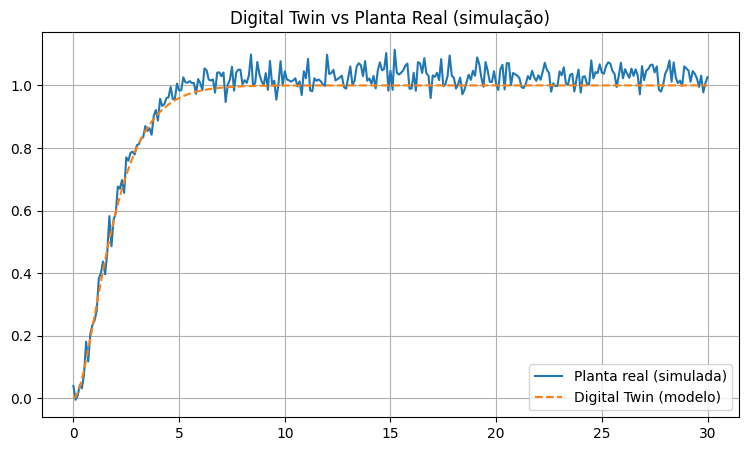

In [2]:
# Planta real (com ruído) e twin (modelo exato)
Gp = ctrl.tf([1], [1, 2, 1])
Tsim = np.linspace(0, 30, 301)

# Resposta do twin (modelo ideal)
t_twin, y_twin = ctrl.step_response(Gp, Tsim)

# Planta "real" com ruído e pequeno desvio de parâmetro
Gp_real = ctrl.tf([1.05], [1, 2.1, 1.02])
t_real, y_real = ctrl.step_response(Gp_real, Tsim)
y_real = y_real + 0.03*np.random.randn(len(y_real))  # ruído

plt.plot(t_real, y_real, label="Planta real (simulada)")
plt.plot(t_twin, y_twin, '--', label="Digital Twin (modelo)")
plt.legend(); plt.title("Digital Twin vs Planta Real (simulação)")
plt.grid(); plt.show()


## 2. APC/RTO simplificado (exemplo)

Implementamos um problema de otimização simplificado que escolhe um setpoint ótimo para minimizar erro e consumo (função quadrática).
Implementação com `cvxpy`.


In [3]:
# dados simples: queremos minimizar (y - r)^2 + lambda*u^2, assumindo relação estática y = k*u
k = 1.0
lambda_reg = 0.1

# variáveis de otimização
u = cp.Variable()
r = cp.Parameter(value=1.0)  # demanda/setpoint desejado
y = k*u

obj = cp.Minimize((y - r)**2 + lambda_reg*cp.square(u))
prob = cp.Problem(obj)
prob.solve()
print("Setpoint otimizado u* =", u.value, "-> saída prevista y* =", (k*u.value))


Setpoint otimizado u* = 0.9090909090909091 -> saída prevista y* = 0.9090909090909091


## 3. Simulação em loop: APC sugere setpoint, controlador local (PID) regula

Fluxo:
1. APC otimiza setpoint r*  
2. controlador local (PID) age para atingir r*  
3. Digital Twin avalia performance futura


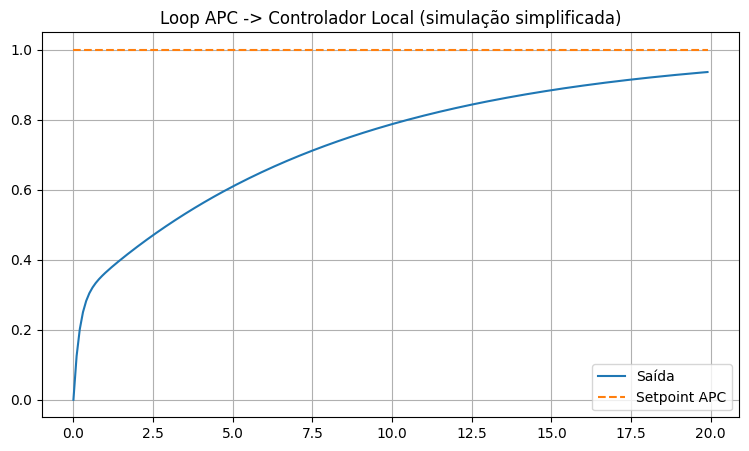

In [4]:
# Controller local simples (PI discretizado) - exemplo simplificado sem discretização explícita
Kp = 1.2; Ki = 0.5

# Simulação discreta (Euler) do loop por N passos
N = 200
dt = 0.1
u_hist = np.zeros(N)
y_hist = np.zeros(N)
r_hist = np.zeros(N)

# APC sugere r* com base em horizonte curto (usamos r=1)
r_star = 1.0
r_hist[:] = r_star

for k in range(1,N):
    e = r_hist[k-1] - y_hist[k-1]
    u_hist[k] = u_hist[k-1] + Kp*(e - (r_hist[k-2]-y_hist[k-2]) if k>1 else e) + Ki*dt*e
    # planta contínua aproximada por Euler de 2ª ordem simplificada:
    y_hist[k] = y_hist[k-1] + dt * (-2*y_hist[k-1] - y_hist[k-1] + u_hist[k])  # simplificado
plt.plot(np.arange(N)*dt, y_hist, label="Saída")
plt.plot(np.arange(N)*dt, r_hist, '--', label="Setpoint APC")
plt.legend(); plt.title("Loop APC -> Controlador Local (simulação simplificada)")
plt.grid(); plt.show()


## 4. Monte-Carlo: variação de latência de rede e ruído de medição

Avalia como a latência e o ruído afetam desempenho do controlador local quando o APC atua com atraso.


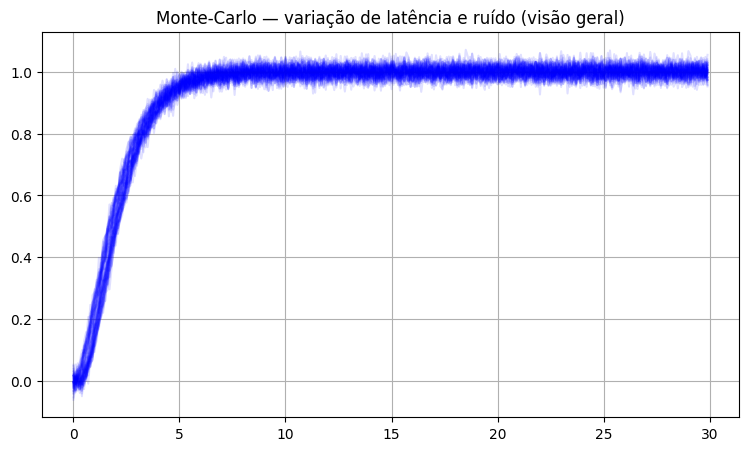

In [6]:
Nsim = 60
dt = 0.1
Tsim = 30
time = np.arange(0, Tsim, dt)

plt.figure()

# Gerar resposta nominal COM O MESMO VETOR DE TEMPO
t, y_nominal = ctrl.step_response(Gp, time)

for sim in range(Nsim):
    # variação aleatória de latência (em segundos) e ruído
    latency = np.random.uniform(0.0, 0.5)
    noise = 0.02 * np.random.randn(len(time))

    # aplicar atraso simples: shift the signal by latency/dt samples
    shift = int(latency / dt)

    if shift > 0:
        y_shifted = np.concatenate([np.zeros(shift), y_nominal[:-shift]])
    else:
        y_shifted = y_nominal.copy()

    # adicionar ruído
    y_noisy = y_shifted + noise

    plt.plot(time, y_noisy, alpha=0.12, color='blue')

plt.title("Monte-Carlo — variação de latência e ruído (visão geral)")
plt.grid()
plt.show()


## 5. Simulação de envio de dados (OPC-UA / MQTT) — exemplo conceitual

Mostrar como um payload de dados (tempo, setpoint, saída medida, alarmes) seria gerado para enviar ao PIMS.


In [7]:
import json
# gerar dados (pequena simulação)
t = np.linspace(0, 10, 101)
t, y = ctrl.step_response(Gp, t)
setpoint = np.ones_like(t)
measured = y + 0.01*np.random.randn(len(t))

payload = {"time": t.tolist(), "setpoint": setpoint.tolist(), "measured": measured.tolist(), "tags": {"unit":"m/s", "plant":"sim1"}}
print(json.dumps(payload)[:800], "...(trecho)")
# Na prática, esse payload seria enviado via MQTT/OPC-UA para o PIMS


{"time": [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4,  ...(trecho)


## Digital Twin com atraso variável e falha simulada de sensor

Nesta célula simulamos:
- atraso variável (rede instável)
- falha temporária de sensor (saltos)
- comparação real vs twin


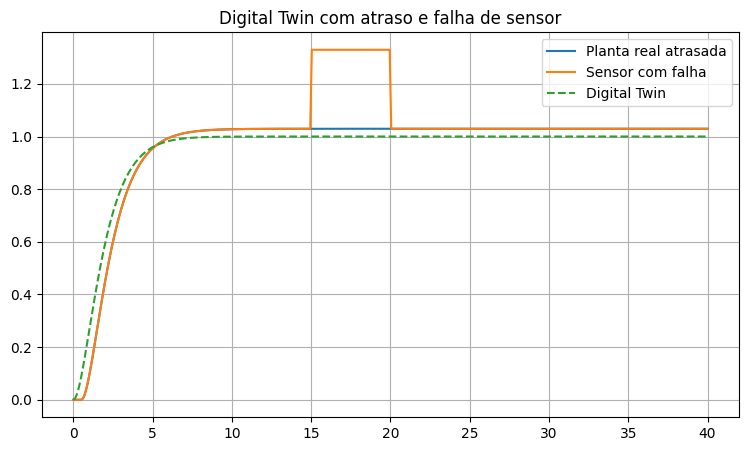

In [8]:
Tsim = np.linspace(0, 40, 400)
t, y_real = ctrl.step_response(Gp_real, Tsim)
t, y_twin = ctrl.step_response(Gp, Tsim)

# atraso variável (rede instável)
delay = np.random.uniform(0.2, 1.0)
shift = int(delay / (Tsim[1]-Tsim[0]))
y_real_d = np.concatenate((np.zeros(shift), y_real[:-shift]))

# falha de sensor
fault = y_real_d.copy()
fault[150:200] += 0.3  # falha tipo offset

plt.plot(t, y_real_d, label="Planta real atrasada")
plt.plot(t, fault, label="Sensor com falha")
plt.plot(t, y_twin, '--', label="Digital Twin")
plt.legend(); plt.grid()
plt.title("Digital Twin com atraso e falha de sensor")
plt.show()


## MPC Linear Simplificado

Criamos um MPC com:
- horizonte de predição Np
- horizonte de controle Nc
- minimização (y - r)^2 + ρ*u^2


/usr/local/lib/python3.12/dist-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


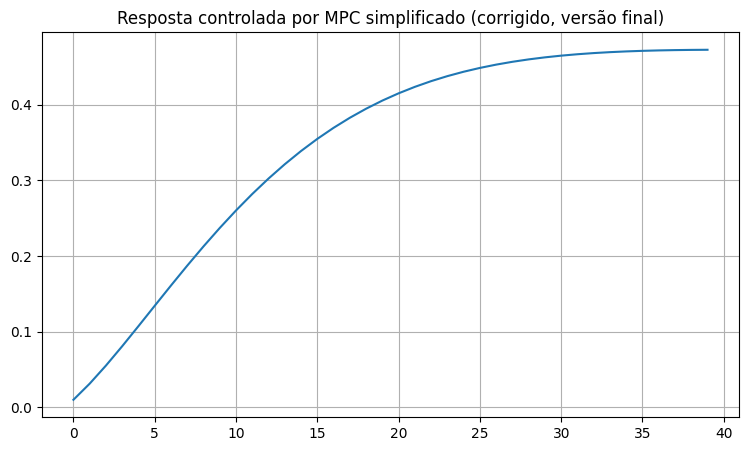

In [12]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# parâmetros MPC
Np = 10
Nc = 3
rho = 0.1

# modelo discreto
Gd = ctrl.sample_system(Gp, 0.1)
A, B, C, D = ctrl.ssdata(ctrl.ss(Gd))

# referência
r = 1.0

# estados
x = np.zeros((A.shape[0], 1))
y_list = []
u_list = []

for k in range(40):

    # variável de controle futura
    u = cp.Variable((Nc, 1))

    cost = 0
    x_pred = x.copy()

    for i in range(Np):

        u_use = u[min(i, Nc-1)]

        # predição
        x_pred = A @ x_pred + B @ u_use

        # saída prevista (1×1)
        y_pred = C @ x_pred   # ★ sem índices!

        # custo escala automaticamente
        cost += cp.sum_squares(y_pred - r) + rho * cp.sum_squares(u_use)

    # resolver MPC
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()

    # aplicar controle
    u_apply = u.value[0,0]
    u_list.append(u_apply)

    x = A @ x + B * u_apply

    y_list.append(float((C @ x)[0,0]))

plt.plot(y_list)
plt.title("Resposta controlada por MPC simplificado (corrigido, versão final)")
plt.grid()
plt.show()


## Monte-Carlo completo: latência + ruído + modelo incorreto

Esta célula roda 100 simulações com:
- atraso variável
- ruído Gaussiano
- planta real diferente do modelo
- saturação do atuador


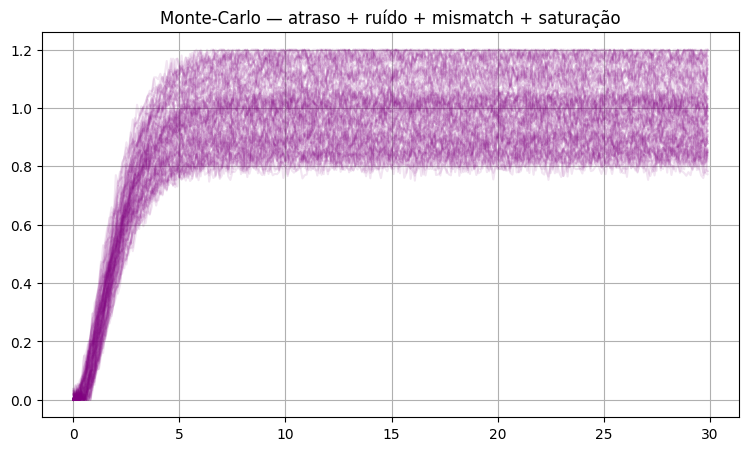

In [14]:
plt.figure()

# tempo de simulação
dt = 0.1
Tsim = 30
t = np.arange(0, Tsim, dt)

for _ in range(100):

    delay = np.random.uniform(0.0, 0.6)
    noise = 0.02 * np.random.randn(len(t))
    scale = np.random.uniform(0.8, 1.2)

    # resposta com o MESMO vetor de tempo
    _, y = ctrl.step_response(Gp * scale, t)

    # atraso em amostras
    shift = int(delay / dt)

    # aplicar atraso com segurança
    if shift > 0:
        y_shift = np.concatenate((np.zeros(shift), y[:-shift]))
    else:
        y_shift = y.copy()

    # ruído + saturação
    y_noisy = y_shift + noise
    y_sat = np.clip(y_noisy, 0, 1.2)

    plt.plot(t, y_sat, alpha=0.1, color='purple')

plt.title("Monte-Carlo — atraso + ruído + mismatch + saturação")
plt.grid()
plt.show()


## Filtro digital eliminando ruído do sensor

Como sensores IIoT possuem ruído elevado, aplicamos um filtro IIR simples:
y_f[k] = 0.8 y_f[k-1] + 0.2 y[k]



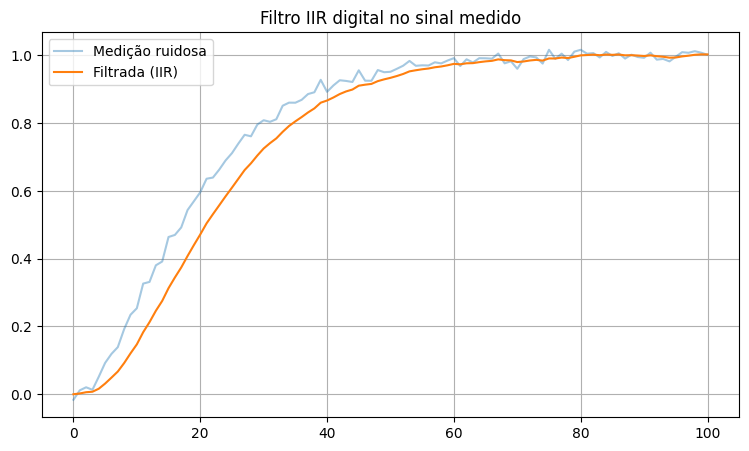

In [15]:
y_f = np.zeros_like(measured)

for k in range(1, len(y_f)):
    y_f[k] = 0.8*y_f[k-1] + 0.2*measured[k]

plt.plot(measured, alpha=0.4, label="Medição ruidosa")
plt.plot(y_f, label="Filtrada (IIR)")
plt.legend(); plt.grid()
plt.title("Filtro IIR digital no sinal medido")
plt.show()


## Conclusões práticas e recomendações

- Sempre testar controladores no Digital Twin com varreduras de parâmetros e Monte-Carlo (latência, ruído).  
- Armazenar séries temporais no PIMS para retroalimentar modelos de RTO e ML.  
- Projetar malhas locais com margens apropriadas para suportar atrasos e incertezas da rede.  
- Usar APC/MPC para otimização econômica, mas apenas sobre controladores locais robustos.
